In [1]:
from typing import List
import pisces.models as pm
from pisces.data_sets import DataSetObject, ModelInputSpectrogram, ModelOutputType, DataProcessor, PSGType

## Set up paths for caching
Set up all the paths here, ensure the (sub)folders all exist so later when we try to save to these there are no errors.

In [2]:

import os
from pathlib import Path

CWD = Path(os.getcwd())
save_path = CWD.joinpath("pre_processed_data")
hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
disordered_path = save_path.joinpath("disordered")
os.makedirs(disordered_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)
# hardcoded data locations are easiest, if most brittle
data_location = Path('/Users/eric/Engineering/Work/pisces/data_sets')
# data_location = Path('/home/eric/Engineering/Work/pisces/data_sets')


In [3]:
data_location

PosixPath('/Users/eric/Engineering/Work/pisces/data_sets')

In [4]:
!pisces_setup

Converting Mads Olsen model to Keras...
Model saved at /Users/eric/Engineering/Work/pisces/pisces/cached_models/mo_resunet.keras


# Walch

In [5]:
sets = DataSetObject.find_data_sets(data_location)
walch = sets['walch_et_al']
walch.parse_data_sets()
print(f"Found {len(walch.ids)} subjects")

hybrid = sets['hybrid_motion']
hybrid.parse_data_sets()
print(f"Found {len(hybrid.ids)} subjects")

Found 31 subjects
Found 31 subjects


In [6]:
subjects_to_exclude_walch = [
    "7749105",
    "5383425", "8258170"
    # "3509524", "5383425",
    # "759667",
    # "8258170",
    # "9961348", "5132496",
]

# SAME subjects, hybrid is fuzzed data
subjects_to_exclude_hybrid = subjects_to_exclude_walch

In [7]:
sampling_hz = 32 # Hz
input_features = ['accelerometer']
model_input = ModelInputSpectrogram(input_features, sampling_hz)
output_type = ModelOutputType.WAKE_LIGHT_DEEP_REM
data_processor_walch = DataProcessor(walch, model_input, output_type=output_type,
                                     psg_type=PSGType.HAS_N4)

In [8]:
mo = pm.MOResUNetPretrained(data_processor=data_processor_walch, sampling_hz=sampling_hz)

In [9]:
import sys
from typing import Dict
import numpy as np
from scipy.signal import spectrogram

from analyses.NHRC.nhrc_utils.model_definitions import LR_ACTIVITY_INPUTS
import pisces.data_sets as pds
from pisces.utils import resample_accel_data

FIXED_LABEL_LENGTH = 1024
# FIXED_SPECGRAM_SHAPE = (15360, 32, 3)
FIXED_SPECGRAM_SHAPE = (15360, 32)

ACC_DIFF_GAP = 10 # seconds
ACC_RAW_HZ = 50
ACC_RAW_DT = 1/ACC_RAW_HZ
ACC_INPUT_HZ = 32
ACTIVITY_RATE = 15
ACTIVITY_HZ = 1/ACTIVITY_RATE
PSG_RATE = 30
PSG_HZ = 1/PSG_RATE
SECONDS_PER_KERNEL = 5 * 60
ACTIVITY_KERNEL_WIDTH = SECONDS_PER_KERNEL * ACTIVITY_HZ
ACTIVITY_KERNEL_WIDTH += 1 - (ACTIVITY_KERNEL_WIDTH % 2)  # Ensure it is odd

def process_data(dataset: pds.DataSetObject, id, ACTIVITY_KERNEL_WIDTH):
    # Load data
    accel_data = dataset.get_feature_data('accelerometer', id).to_numpy()
    activity_data = dataset.get_feature_data('activity', id).to_numpy()
    psg_data = dataset.get_feature_data('psg', id).to_numpy()

    # Sort based on time (axis 0)
    accel_data = accel_data[accel_data[:, 0].argsort()]
    activity_data = activity_data[activity_data[:, 0].argsort()]
    psg_data = psg_data[psg_data[:, 0].argsort()]

    # Convert activity and PSG time to int
    activity_data[:, 0] = np.round(activity_data[:, 0])
    psg_data[:, 0] = np.round(psg_data[:, 0])
    
    # Trim data to common time range
    start_time = max(accel_data[0, 0], activity_data[0, 0], psg_data[0, 0])
    end_time = min(accel_data[-1, 0], activity_data[-1, 0], psg_data[-1, 0])
    
    accel_data = accel_data[(accel_data[:, 0] >= start_time) & (accel_data[:, 0] <= end_time)]
    activity_data = activity_data[(activity_data[:, 0] >= start_time) & (activity_data[:, 0] <= end_time)]
    psg_data = psg_data[(psg_data[:, 0] >= start_time) & (psg_data[:, 0] <= end_time)]

    # print("PSG Shape", psg_data.shape)
    
    # Find gaps in accelerometer data
    time_diff = np.diff(accel_data[:, 0])
    avg_time_hz = int(1/np.median(time_diff))
    avg_time_diff = 1/avg_time_hz
    gap_indices = np.where(time_diff > ACC_DIFF_GAP)[0]
    
    # Mask PSG labels during accelerometer gaps
    n_psg_mask = np.sum(psg_data[:, 1] < 0)
    len_psg = psg_data.shape[0]
    # print("# of masked epochs: ", n_psg_mask, "out of", len_psg, f"({100 * n_psg_mask / len_psg:.2f}%)")
    pre_mask_sleeps = np.sum(psg_data[:, 1] > 0)
    pre_mask_wakes = np.sum(psg_data[:, 1] == 0)
    wakes_masked = 0
    print("Pre-mask:\n\tSleeps", pre_mask_sleeps, "\n\tWakes", pre_mask_wakes)
    for gap_index in gap_indices:
        gap_start = accel_data[gap_index, 0] + avg_time_diff
        gap_end = accel_data[gap_index + 1, 0]
        mask_indices = np.where((psg_data[:, 0] + PSG_RATE >= gap_start) & (psg_data[:, 0] <= gap_end))[0]
        wake_counts = np.sum((psg_data[mask_indices, 1].astype(int)) == 0)
        wakes_masked += wake_counts
        sleep_counts = np.sum((psg_data[mask_indices, 1].astype(int)) > 0)
        psg_data[mask_indices, 1:] = -1  # Assuming labels are in columns from index 1 onwards
    
    post_mask_sleeps = np.sum(psg_data[:, 1] > 0)
    post_mask_wakes = np.sum(psg_data[:, 1] == 0)
    print("Post-mask:\n\tSleeps", post_mask_sleeps, "\n\tWakes", post_mask_wakes, "\n\tWakes masked", wakes_masked)
    
    # Convert accelerometer data to spectrograms
    accel_data_resampled = resample_accel_data(accel_data, original_fs=int(avg_time_hz), target_fs=ACC_INPUT_HZ)
    spectrograms = data_processor_walch.accelerometer_to_spectrogram(accel_data_resampled)
    padded_spectrograms = np.zeros(FIXED_SPECGRAM_SHAPE)
    padded_spectrograms[:spectrograms.shape[0], ...] = spectrograms[:FIXED_SPECGRAM_SHAPE[0], ...]
    
    # Pad PSG data to 1024 samples
    psg_data = pad_or_truncate(psg_data, int(FIXED_LABEL_LENGTH))
    
    # Pad activity data to 2 * 1024 samples
    activity_data = pad_or_truncate(activity_data, int(LR_ACTIVITY_INPUTS))
    
    return {"spectrogram": padded_spectrograms, "activity": activity_data, "psg": psg_data}

import numpy as np
def pad_or_truncate(data, desired_length, pad_value: float = -1.0):
    current_length = data.shape[0]
    if current_length < desired_length:
        padding = desired_length - current_length
        pad_width = ((0, padding), (0, 0))
        data = np.pad(data, pad_width, mode='constant', constant_values=pad_value)
    else:
        data = data[:desired_length, :]
    return data


LR_KERNEL_SIZE: 61


In [10]:
def process_data_set(data_set: pds.DataSetObject, ids_to_exclude: List[str], ACTIVITY_KERNEL_WIDTH):
    data = {}
    for id in data_set.ids:
        if id in ids_to_exclude:
            continue
        print(f"Processing {id}")
        data[id] = process_data(data_set, id, ACTIVITY_KERNEL_WIDTH)
    return data

In [11]:
preprocessed_data_walch = process_data_set(walch, subjects_to_exclude_walch, ACTIVITY_KERNEL_WIDTH)
preprocessed_data_hybrid = process_data_set(hybrid, subjects_to_exclude_hybrid, ACTIVITY_KERNEL_WIDTH)

Processing 1066528
Pre-mask:
	Sleeps 767 
	Wakes 179
Post-mask:
	Sleeps 618 
	Wakes 139 
	Wakes masked 40
Processing 1360686
Pre-mask:
	Sleeps 831 
	Wakes 93
Post-mask:
	Sleeps 828 
	Wakes 93 
	Wakes masked 0
Processing 1449548
Pre-mask:
	Sleeps 848 
	Wakes 104
Post-mask:
	Sleeps 744 
	Wakes 97 
	Wakes masked 7
Processing 1455390
Pre-mask:
	Sleeps 871 
	Wakes 84
Post-mask:
	Sleeps 871 
	Wakes 84 
	Wakes masked 0
Processing 1818471
Pre-mask:
	Sleeps 948 
	Wakes 10
Post-mask:
	Sleeps 948 
	Wakes 10 
	Wakes masked 0
Processing 2598705
Pre-mask:
	Sleeps 934 
	Wakes 20
Post-mask:
	Sleeps 744 
	Wakes 14 
	Wakes masked 6
Processing 2638030
Pre-mask:
	Sleeps 825 
	Wakes 123
Post-mask:
	Sleeps 825 
	Wakes 123 
	Wakes masked 0
Processing 3509524
Pre-mask:
	Sleeps 363 
	Wakes 52
Post-mask:
	Sleeps 363 
	Wakes 52 
	Wakes masked 0
Processing 3997827
Pre-mask:
	Sleeps 933 
	Wakes 25
Post-mask:
	Sleeps 933 
	Wakes 25 
	Wakes masked 0
Processing 4018081
Pre-mask:
	Sleeps 419 
	Wakes 79
Post-mask:
	Sle

In [12]:
# Prepare a bundle to save
save_preprocessing_to = walch_path.joinpath("walch_preprocessed_data.npy")
print(f"Saving to {save_preprocessing_to}...")

with open(save_preprocessing_to, 'wb') as f:
    np.save(f, preprocessed_data_walch)

save_preprocessing_to = hybrid_path.joinpath("hybrid_preprocessed_data.npy")
print(f"Saving to {save_preprocessing_to}...")
with open(save_preprocessing_to, 'wb') as f:
    np.save(f, preprocessed_data_hybrid)

Saving to /Users/eric/Engineering/Work/pisces/analyses/NHRC/pre_processed_data/walch/walch_preprocessed_data.npy...
Saving to /Users/eric/Engineering/Work/pisces/analyses/NHRC/pre_processed_data/hybrid/hybrid_preprocessed_data.npy...


In [13]:
accel = walch.get_feature_data('accelerometer', '1066528')
psg = walch.get_feature_data('psg', '1066528')

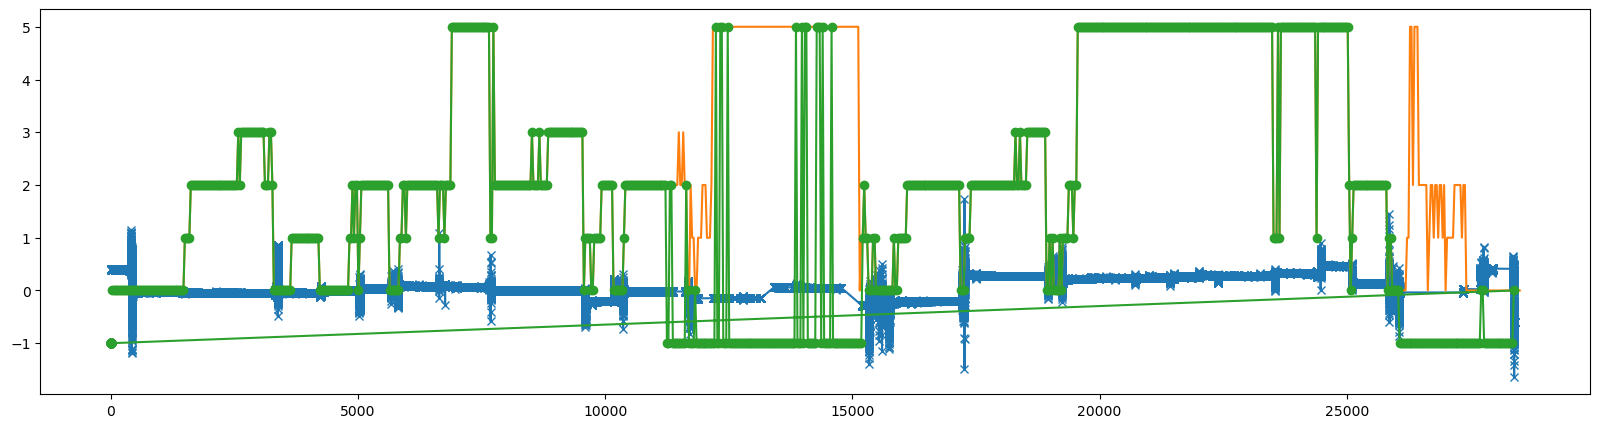

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(accel[:, 0], accel[:, 1], 'x-')
plt.plot(psg[:, 0], psg[:, 1], )

masked_psg = preprocessed_data_walch['1066528']['psg']
plt.plot(masked_psg[:, 0], masked_psg[:, 1], 'o-')

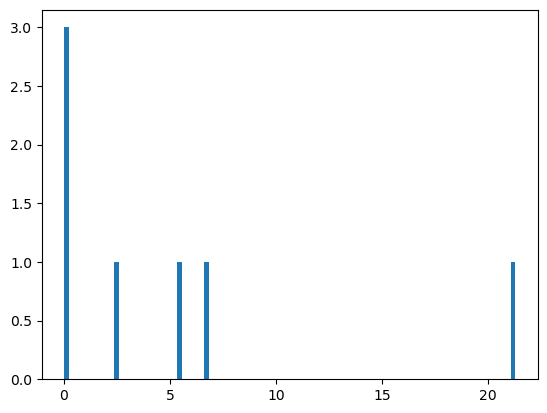

In [15]:
last_times = np.diff(accel[-50 * 20 * 60:, 0])
last_times = last_times[last_times > 1]
last_times /= 60
_ = plt.hist(last_times, bins=100)